# Agents

AutoGen AgentChat provides a set of preset Agents, each with variations in how an agent might respond to messages.
All agents share the following attributes and methods:

- {py:attr}`~autogen_agentchat.agents.BaseChatAgent.name`: The unique name of the agent.
- {py:attr}`~autogen_agentchat.agents.BaseChatAgent.description`: The description of the agent in text.
- {py:meth}`~autogen_agentchat.agents.BaseChatAgent.on_messages`: Send the agent a sequence of {py:class}`~autogen_agentchat.messages.ChatMessage` and get a {py:class}`~autogen_agentchat.base.Response`. **It is important to note that agents are expected to be stateful and this method is expected to be called with new messages, not the complete history**.
- {py:meth}`~autogen_agentchat.agents.BaseChatAgent.on_messages_stream`: Same as {py:meth}`~autogen_agentchat.agents.BaseChatAgent.on_messages` but returns an iterator of {py:class}`~autogen_agentchat.messages.AgentEvent` or {py:class}`~autogen_agentchat.messages.ChatMessage` followed by a {py:class}`~autogen_agentchat.base.Response` as the last item.
- {py:meth}`~autogen_agentchat.agents.BaseChatAgent.on_reset`: Reset the agent to its initial state.
- {py:meth}`~autogen_agentchat.agents.BaseChatAgent.run` and {py:meth}`~autogen_agentchat.agents.BaseChatAgent.run_stream`: convenience methods that call {py:meth}`~autogen_agentchat.agents.BaseChatAgent.on_messages` and {py:meth}`~autogen_agentchat.agents.BaseChatAgent.on_messages_stream` respectively but offer the same interface as [Teams](./teams.ipynb).

See {py:mod}`autogen_agentchat.messages` for more information on AgentChat message types.


## Assistant Agent

{py:class}`~autogen_agentchat.agents.AssistantAgent` is a built-in agent that
uses a language model and has the ability to use tools.

In [1]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_agentchat.ui import Console
from autogen_core import CancellationToken
from autogen_ext.models.openai import OpenAIChatCompletionClient

In [13]:
# Define a tool that searches the web for information.
async def web_search(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


# Create an agent that uses the OpenAI GPT-4o model.
model_client = OpenAIChatCompletionClient(
    model="gpt-4o",
    # api_key="YOUR_API_KEY",
)
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)


## Getting Responses

We can use the {py:meth}`~autogen_agentchat.agents.AssistantAgent.on_messages` method to get the agent response to a given message.


In [12]:
async def assistant_run() -> None:
    response = await agent.on_messages(
        [TextMessage(content="Find information on AutoGen", source="user")],
        cancellation_token=CancellationToken(),
    )
    print(response.inner_messages)
    print(response.chat_message)


# Use asyncio.run(assistant_run()) when running in a script.
await assistant_run()

[ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=598, completion_tokens=16), content=[FunctionCall(id='call_9UWYM1CgE3ZbnJcSJavNDB79', arguments='{"query":"AutoGen"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='assistant', models_usage=None, content=[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', call_id='call_9UWYM1CgE3ZbnJcSJavNDB79', is_error=False)], type='ToolCallExecutionEvent')]
source='assistant' models_usage=None content='AutoGen is a programming framework for building multi-agent applications.' type='ToolCallSummaryMessage'


The call to the {py:meth}`~autogen_agentchat.agents.AssistantAgent.on_messages` method
returns a {py:class}`~autogen_agentchat.base.Response`
that contains the agent's final response in the {py:attr}`~autogen_agentchat.base.Response.chat_message` attribute,
as well as a list of inner messages in the {py:attr}`~autogen_agentchat.base.Response.inner_messages` attribute,
which stores the agent's "thought process" that led to the final response.

```{note}
It is important to note that {py:meth}`~autogen_agentchat.agents.AssistantAgent.on_messages`
will update the internal state of the agent -- it will add the messages to the agent's
history. So you should call this method with new messages.
**You should not repeatedly call this method with the same messages or the complete history.**
```

```{note}
Unlike in v0.2 AgentChat, the tools are executed by the same agent directly within
the same call to {py:meth}`~autogen_agentchat.agents.AssistantAgent.on_messages`.
By default, the agent will return the result of the tool call as the final response.
```

You can also call the {py:meth}`~autogen_agentchat.agents.BaseChatAgent.run` method, which is a convenience method that calls {py:meth}`~autogen_agentchat.agents.BaseChatAgent.on_messages`. 
It follows the same interface as [Teams](./teams.ipynb) and returns a {py:class}`~autogen_agentchat.base.TaskResult` object.

## Multi-Modal Input

The {py:class}`~autogen_agentchat.agents.AssistantAgent` can handle multi-modal input
by providing the input as a {py:class}`~autogen_agentchat.messages.MultiModalMessage`.


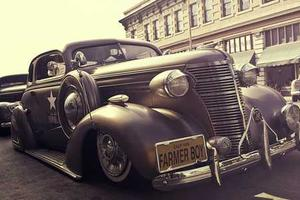

In [ ]:
from io import BytesIO

import PIL
import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image

# Create a multi-modal message with random image and text.
pil_image = PIL.Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))
img = Image(pil_image)
multi_modal_message = MultiModalMessage(content=["Can you describe the content of this image?", img], source="user")
img

In [ ]:
# Use asyncio.run(...) when running in a script.
response = await agent.on_messages([multi_modal_message], CancellationToken())
print(response.chat_message)

The image depicts a vintage car, likely from the 1930s or 1940s, with a sleek, classic design. The car seems to be customized or well-maintained, as indicated by its shiny exterior and lowered stance. It has a prominent grille and round headlights. There's a license plate on the front with the text "FARMER BOY." The setting appears to be a street with old-style buildings in the background, suggesting a historical or retro theme.


You can also use {py:class}`~autogen_agentchat.messages.MultiModalMessage` as a `task`
input to the {py:meth}`~autogen_agentchat.agents.BaseChatAgent.run` method.

## Streaming Messages

We can also stream each message as it is generated by the agent by using the
{py:meth}`~autogen_agentchat.agents.AssistantAgent.on_messages_stream` method,
and use {py:class}`~autogen_agentchat.ui.Console` to print the messages
as they appear to the console.

In [ ]:
async def assistant_run_stream() -> None:
    # Option 1: read each message from the stream (as shown in the previous example).
    # async for message in agent.on_messages_stream(
    #     [TextMessage(content="Find information on AutoGen", source="user")],
    #     cancellation_token=CancellationToken(),
    # ):
    #     print(message)

    # Option 2: use Console to print all messages as they appear.
    await Console(
        agent.on_messages_stream(
            [TextMessage(content="Find information on AutoGen", source="user")],
            cancellation_token=CancellationToken(),
        ),
        output_stats=True,  # Enable stats printing.
    )


# Use asyncio.run(assistant_run_stream()) when running in a script.
await assistant_run_stream()

---------- assistant ----------
[FunctionCall(id='call_fSp5iTGVm2FKw5NIvfECSqNd', arguments='{"query":"AutoGen information"}', name='web_search')]
[Prompt tokens: 61, Completion tokens: 16]
---------- assistant ----------
[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', call_id='call_fSp5iTGVm2FKw5NIvfECSqNd')]
---------- assistant ----------
AutoGen is a programming framework designed for building multi-agent applications. If you need more detailed information or specific aspects about AutoGen, feel free to ask!
[Prompt tokens: 93, Completion tokens: 32]
---------- Summary ----------
Number of inner messages: 2
Total prompt tokens: 154
Total completion tokens: 48
Duration: 4.30 seconds


The {py:meth}`~autogen_agentchat.agents.AssistantAgent.on_messages_stream` method
returns an asynchronous generator that yields each inner message generated by the agent,
with the final item being the response message in the {py:attr}`~autogen_agentchat.base.Response.chat_message` attribute.

From the messages, you can observe that the assistant agent utilized the `web_search` tool to
gather information and responded based on the search results.

You can also use {py:meth}`~autogen_agentchat.agents.BaseChatAgent.run_stream` to get the same streaming behavior as {py:meth}`~autogen_agentchat.agents.BaseChatAgent.on_messages_stream`. It follows the same interface as [Teams](./teams.ipynb).

## Using Tools

Large Language Models (LLMs) are typically limited to generating text or code responses. 
However, many complex tasks benefit from the ability to use external tools that perform specific actions,
such as fetching data from APIs or databases.

To address this limitation, modern LLMs can now accept a list of available tool schemas 
(descriptions of tools and their arguments) and generate a tool call message. 
This capability is known as **Tool Calling** or **Function Calling** and 
is becoming a popular pattern in building intelligent agent-based applications.
Refer to the documentation from [OpenAI](https://platform.openai.com/docs/guides/function-calling) 
and [Anthropic](https://docs.anthropic.com/en/docs/build-with-claude/tool-use) for more information about tool calling in LLMs.

In AgentChat, the {py:class}`~autogen_agentchat.agents.AssistantAgent` can use tools to perform specific actions.
The `web_search` tool is one such tool that allows the assistant agent to search the web for information.
A custom tool can be a Python function or a subclass of the {py:class}`~autogen_core.tools.BaseTool`.

```{note}
For how to use model clients directly with tools, refer to the [Tools](../../core-user-guide/components/tools.ipynb) section
in the Core User Guide.
```

By default, when {py:class}`~autogen_agentchat.agents.AssistantAgent` executes a tool,
it will return the tool's output as a string in {py:class}`~autogen_agentchat.messages.ToolCallSummaryMessage` in its response.
If your tool does not return a well-formed string in natural language, you
can add a reflection step to have the model summarize the tool's output,
by setting the `reflect_on_tool_use=True` parameter in the {py:class}`~autogen_agentchat.agents.AssistantAgent` constructor.

### Built-in Tools

AutoGen Extension provides a set of built-in tools that can be used with the Assistant Agent.
Head over to the [API documentation](../../../reference/index.md) for all the available tools
under the `autogen_ext.tools` namespace. For example, you can find the following tools:

- {py:mod}`~autogen_ext.tools.graphrag`: Tools for using GraphRAG index.
- {py:mod}`~autogen_ext.tools.http`: Tools for making HTTP requests.
- {py:mod}`~autogen_ext.tools.langchain`: Adaptor for using LangChain tools.
- {py:mod}`~autogen_ext.tools.mcp`: Tools for using Model Chat Protocol (MCP) servers.

### Function Tool

The {py:class}`~autogen_agentchat.agents.AssistantAgent` automatically
converts a Python function into a {py:class}`~autogen_core.tools.FunctionTool`
which can be used as a tool by the agent and automatically generates the tool schema
from the function signature and docstring.

The `web_search_func` tool is an example of a function tool.
The schema is automatically generated.

In [ ]:
from autogen_core.tools import FunctionTool


# Define a tool using a Python function.
async def web_search_func(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


# This step is automatically performed inside the AssistantAgent if the tool is a Python function.
web_search_function_tool = FunctionTool(web_search_func, description="Find information on the web")
# The schema is provided to the model during AssistantAgent's on_messages call.
web_search_function_tool.schema

{'name': 'web_search_func',
 'description': 'Find information on the web',
 'parameters': {'type': 'object',
  'properties': {'query': {'description': 'query',
    'title': 'Query',
    'type': 'string'}},
  'required': ['query'],
  'additionalProperties': False},
 'strict': False}

### Model Context Protocol Tools

The {py:class}`~autogen_agentchat.agents.AssistantAgent` can also use tools that are
served from a Model Context Protocol (MCP) server
using {py:func}`~autogen_ext.tools.mcp.mcp_server_tools`.

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_ext.tools.mcp import StdioServerParams, mcp_server_tools

# Get the fetch tool from mcp-server-fetch.
fetch_mcp_server = StdioServerParams(command="uvx", args=["mcp-server-fetch"])
tools = await mcp_server_tools(fetch_mcp_server)

# Create an agent that can use the fetch tool.
model_client = OpenAIChatCompletionClient(model="gpt-4o")
agent = AssistantAgent(name="fetcher", model_client=model_client, tools=tools, reflect_on_tool_use=True)  # type: ignore

# Let the agent fetch the content of a URL and summarize it.
result = await agent.run(task="Summarize the content of https://en.wikipedia.org/wiki/Seattle")
assert isinstance(result.messages[-1], TextMessage)
print(result.messages[-1].content)

# Close the connection to the model client.
await model_client.close()

Seattle, located in Washington state, is the most populous city in the state and a major city in the Pacific Northwest region of the United States. It's known for its vibrant cultural scene, significant economic presence, and rich history. Here are some key points about Seattle from the Wikipedia page:

1. **History and Geography**: Seattle is situated between Puget Sound and Lake Washington, with the Cascade Range to the east and the Olympic Mountains to the west. Its history is deeply rooted in Native American heritage and its development was accelerated with the arrival of settlers in the 19th century. The city was officially incorporated in 1869.

2. **Economy**: Seattle is a major economic hub with a diverse economy anchored by sectors like aerospace, technology, and retail. It's home to influential companies such as Amazon and Starbucks, and has a significant impact on the tech industry due to companies like Microsoft and other technology enterprises in the surrounding area.

3. 

### Langchain Tools

You can also use tools from the Langchain library
by wrapping them in {py:class}`~autogen_ext.tools.langchain.LangChainToolAdapter`.

In [ ]:
import pandas as pd
from autogen_ext.tools.langchain import LangChainToolAdapter
from langchain_experimental.tools.python.tool import PythonAstREPLTool

df = pd.read_csv("https://raw.githubusercontent.com/pandas-dev/pandas/main/doc/data/titanic.csv")
tool = LangChainToolAdapter(PythonAstREPLTool(locals={"df": df}))
model_client = OpenAIChatCompletionClient(model="gpt-4o")
agent = AssistantAgent(
    "assistant", tools=[tool], model_client=model_client, system_message="Use the `df` variable to access the dataset."
)
await Console(
    agent.on_messages_stream(
        [TextMessage(content="What's the average age of the passengers?", source="user")], CancellationToken()
    ),
    output_stats=True,
)

await model_client.close()

---------- assistant ----------
[FunctionCall(id='call_BEYRkf53nBS1G2uG60wHP0zf', arguments='{"query":"df[\'Age\'].mean()"}', name='python_repl_ast')]
[Prompt tokens: 111, Completion tokens: 22]
---------- assistant ----------
[FunctionExecutionResult(content='29.69911764705882', call_id='call_BEYRkf53nBS1G2uG60wHP0zf')]
---------- assistant ----------
29.69911764705882
---------- Summary ----------
Number of inner messages: 2
Total prompt tokens: 111
Total completion tokens: 22
Duration: 0.62 seconds


Response(chat_message=ToolCallSummaryMessage(source='assistant', models_usage=None, content='29.69911764705882', type='ToolCallSummaryMessage'), inner_messages=[ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=111, completion_tokens=22), content=[FunctionCall(id='call_BEYRkf53nBS1G2uG60wHP0zf', arguments='{"query":"df[\'Age\'].mean()"}', name='python_repl_ast')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='assistant', models_usage=None, content=[FunctionExecutionResult(content='29.69911764705882', call_id='call_BEYRkf53nBS1G2uG60wHP0zf')], type='ToolCallExecutionEvent')])

### Parallel Tool Calls

Some models support parallel tool calls, which can be useful for tasks that require multiple tools to be called simultaneously.
By default, if the model client produces multiple tool calls, {py:class}`~autogen_agentchat.agents.AssistantAgent`
will call the tools in parallel.

You may want to disable parallel tool calls when the tools have side effects that may interfere with each other, or,
when agent behavior needs to be consistent across different models.
This should be done at the model client level.

For {py:class}`~autogen_ext.models.openai.OpenAIChatCompletionClient` and {py:class}`~autogen_ext.models.openai.AzureOpenAIChatCompletionClient`,
set `parallel_tool_calls=False` to disable parallel tool calls.

In [ ]:
model_client_no_parallel_tool_call = OpenAIChatCompletionClient(
    model="gpt-4o",
    parallel_tool_calls=False,  # type: ignore
)
agent_no_parallel_tool_call = AssistantAgent(
    name="assistant",
    model_client=model_client_no_parallel_tool_call,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

## Running an Agent in a Loop

The {py:class}`~autogen_agentchat.agents.AssistantAgent` executes one
step at a time: one model call, followed by one tool call (or parallel tool calls), and then
an optional reflection.

To run it in a loop, for example, running it until it stops producing
tool calls, please refer to [Single-Agent Team](./teams.ipynb#single-agent-team).

## Structured Output

Structured output allows models to return structured JSON text with pre-defined schema
provided by the application. Different from JSON-mode, the schema can be provided
as a [Pydantic BaseModel](https://docs.pydantic.dev/latest/concepts/models/)
class, which can also be used to validate the output. 

```{note}
Structured output is only available for models that support it. It also
requires the model client to support structured output as well.
Currently, the {py:class}`~autogen_ext.models.openai.OpenAIChatCompletionClient`
and {py:class}`~autogen_ext.models.openai.AzureOpenAIChatCompletionClient`
support structured output.
```

Structured output is also useful for incorporating Chain-of-Thought
reasoning in the agent's responses.
See the example below for how to use structured output with the assistant agent.

In [2]:
from typing import Literal

from pydantic import BaseModel


# The response format for the agent as a Pydantic base model.
class AgentResponse(BaseModel):
    thoughts: str
    response: Literal["happy", "sad", "neutral"]


# Create an agent that uses the OpenAI GPT-4o model with the custom response format.
model_client = OpenAIChatCompletionClient(
    model="gpt-4o",
    response_format=AgentResponse,  # type: ignore
)
agent = AssistantAgent(
    "assistant",
    model_client=model_client,
    system_message="Categorize the input as happy, sad, or neutral following the JSON format.",
)

await Console(agent.run_stream(task="I am happy."))
await model_client.close()

---------- user ----------
I am happy.
---------- assistant ----------
{"thoughts":"The user explicitly states that they are happy.","response":"happy"}


TaskResult(messages=[TextMessage(source='user', models_usage=None, content='I am happy.', type='TextMessage'), TextMessage(source='assistant', models_usage=RequestUsage(prompt_tokens=89, completion_tokens=18), content='{"thoughts":"The user explicitly states that they are happy.","response":"happy"}', type='TextMessage')], stop_reason=None)

## Streaming Tokens

You can stream the tokens generated by the model client by setting `model_client_stream=True`.
This will cause the agent to yield {py:class}`~autogen_agentchat.messages.ModelClientStreamingChunkEvent` messages
in {py:meth}`~autogen_agentchat.agents.BaseChatAgent.on_messages_stream` and {py:meth}`~autogen_agentchat.agents.BaseChatAgent.run_stream`.

The underlying model API must support streaming tokens for this to work.
Please check with your model provider to see if this is supported.

In [ ]:
model_client = OpenAIChatCompletionClient(model="gpt-4o")

streaming_assistant = AssistantAgent(
    name="assistant",
    model_client=model_client,
    system_message="You are a helpful assistant.",
    model_client_stream=True,  # Enable streaming tokens.
)

# Use an async function and asyncio.run() in a script.
async for message in streaming_assistant.on_messages_stream(  # type: ignore
    [TextMessage(content="Name two cities in South America", source="user")],
    cancellation_token=CancellationToken(),
):
    print(message)

source='assistant' models_usage=None content='Two' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' cities' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' in' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' South' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' America' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' are' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' Buenos' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' Aires' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' in' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' Argentina' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' and' type='ModelClientStreamingChunk

You can see the streaming chunks in the output above.
The chunks are generated by the model client and are yielded by the agent as they are received.
The final response, the concatenation of all the chunks, is yielded right after the last chunk.

Similarly, {py:meth}`~autogen_agentchat.agents.BaseChatAgent.run_stream` will also yield the same streaming chunks,
followed by a full text message right after the last chunk.

In [ ]:
async for message in streaming_assistant.run_stream(task="Name two cities in North America."):  # type: ignore
    print(message)

source='user' models_usage=None content='Name two cities in North America.' type='TextMessage'
source='assistant' models_usage=None content='Two' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' cities' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' in' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' North' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' America' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' are' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' New' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' York' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' City' type='ModelClientStreamingChunkEvent'
source='assistant' models_usage=None content=' in' type='ModelClientStreamingChunkEven

## Using Model Context

{py:class}`~autogen_agentchat.agents.AssistantAgent` has a `model_context`
parameter that can be used to pass in a {py:class}`~autogen_core.model_context.ChatCompletionContext`
object. This allows the agent to use different model contexts, such as
{py:class}`~autogen_core.model_context.BufferedChatCompletionContext` to
limit the context sent to the model.

By default, {py:class}`~autogen_agentchat.agents.AssistantAgent` uses
the {py:class}`~autogen_core.model_context.UnboundedChatCompletionContext`
which sends the full conversation history to the model. To limit the context
to the last `n` messages, you can use the {py:class}`~autogen_core.model_context.BufferedChatCompletionContext`.

In [ ]:
from autogen_core.model_context import BufferedChatCompletionContext

# Create an agent that uses only the last 5 messages in the context to generate responses.
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
    model_context=BufferedChatCompletionContext(buffer_size=5),  # Only use the last 5 messages in the context.
)

## Other Preset Agents

The following preset agents are available:

- {py:class}`~autogen_agentchat.agents.UserProxyAgent`: An agent that takes user input returns it as responses.
- {py:class}`~autogen_agentchat.agents.CodeExecutorAgent`: An agent that can execute code.
- {py:class}`~autogen_ext.agents.openai.OpenAIAssistantAgent`: An agent that is backed by an OpenAI Assistant, with ability to use custom tools.
- {py:class}`~autogen_ext.agents.web_surfer.MultimodalWebSurfer`: A multi-modal agent that can search the web and visit web pages for information.
- {py:class}`~autogen_ext.agents.file_surfer.FileSurfer`: An agent that can search and browse local files for information.
- {py:class}`~autogen_ext.agents.video_surfer.VideoSurfer`: An agent that can watch videos for information.

## Next Step

Having explored the usage of the {py:class}`~autogen_agentchat.agents.AssistantAgent`, we can now proceed to the next section to learn about the teams feature in AgentChat.


<!-- ## CodingAssistantAgent

Generates responses (text and code) using an LLM upon receipt of a message. It takes a `system_message` argument that defines or sets the tone for how the agent's LLM should respond. 

```python

writing_assistant_agent = CodingAssistantAgent(
    name="writing_assistant_agent",
    system_message="You are a helpful assistant that solve tasks by generating text responses and code.",
    model_client=model_client,
)
`

We can explore or test the behavior of the agent by sending a message to it using the  {py:meth}`~autogen_agentchat.agents.BaseChatAgent.on_messages`  method. 

```python
result = await writing_assistant_agent.on_messages(
    messages=[
        TextMessage(content="What is the weather right now in France?", source="user"),
    ],
    cancellation_token=CancellationToken(),
)
print(result) -->